## Introduction
**This Jupyter Notebook** is dedicated to addressing the insightful feedback from our reviewer regarding the visualization of features extracted by our network, named **STEN**. The visualization efforts documented here are crucial for enhancing the understanding of how STEN processes and learns from the data. This notebook has been crafted following an adaptation and extension of the methodologies from the N-BEATS model available on [Philippe Rémy's GitHub repository](https://github.com/philipperemy/n-beats/tree/master). Our modifications are specifically aimed at further exploring the features extracted by the network, tailored to geophysical phenomena like landslides and surface deformation.

### Methodological Adaptation
In adapting the code from the above repository, we have focused on refining the **interpretability of the model** rather than altering the feature extraction process itself. Originally, the model primarily elucidated the seasonal and trend components of the predictions. Our modifications have restructured the network to articulate the features output by each stack (generic seasonality and trend) throughout the prediction process. This enhancement is designed to provide a clearer understanding of how the model achieves improved forecasting accuracy by delineating the contribution of each component.

### Experiments Conducted
- **1. Synthetic Data Simulation:** We simulated ground deformation observations exhibiting cyclical and large-scale gradual rising trends. Using modified STEN (or Nbeats) to visualize the features extracted at each network layer from these data, helping elucidate the network's ability to capture temporal patterns.
- **2. Hydrological Factors in Reservoir Landslides:** We analyzed the time series of deformations in reservoir landslides controlled by various periodic hydrological factors. Feature extraction from these series was visualized, and a wavelet function analysis was conducted to compare the seasonal components of predicted and observed values across different epochs.
- **3. Creep and Oscillatory Sliding Modes Linked to Precipitation:** We examined the features learned from creep landslide deformation patterns that have correlations with precipitation, including oscillatory sliding modes.
- **4. Short-Term Oscillatory Patterns in Creeping Landslides:** We investigated another temporal scale, specifically a 3-hour oscillatory pattern in creep landslides, to understand the short-term dynamics the network can capture.

---


Additionally, we wish to acknowledge that we have not extensively tuned the parameters. We recognize that further refinement may unveil intriguing findings and offer additional insights. This aspect will be a significant focus of our future work. Moreover, by making our code publicly available, we encourage the community to join us in this exploration, contributing to and expanding upon our initial findings.








First, this notebook presents the features extracted by our STEN from synthetic datasets. This serves as a primer demonstration of STEN's capabilities and limitations in detecting seasonality and trend patterns.


In [ ]:
import pickle
import random
from time import time
from typing import Union

import itertools
import warnings

import matplotlib
import matplotlib.pyplot as plt
import numpy as np



import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.nn.functional import mse_loss, l1_loss, binary_cross_entropy, cross_entropy
from torch.optim import Optimizer

warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 7})

# Enhanced Feature Extraction
In the revised version, we have focused on enhancing the feature extraction capabilities and improving interpretability by modifying how outputs are managed within the network's architecture. Below, we outline the key changes implemented in the methods get_generic_and_interpretable_outputs and forward to achieve these enhancements.



<br>**Method: get_generic_and_interpretable_outputs**<br>
This method is designed to segregate and accumulate the generic (g) and interpretable (i) predictions from each layer of the network. The method starts by initializing arrays for storing forecasts and backcasts for both types of outputs:

```python
g_pred_forecast = np.zeros(self.forecast_length)
i_pred_forecast = np.zeros(self.forecast_length)
g_pred_backcast = np.zeros(self.backcast_length)
i_pred_backcast = np.zeros(self.backcast_length)
```
A dictionary is also initiated to keep track of outputs by each layer, which aids in debugging and further analysis:

```python
outputs = {}
```

The method iterates over intermediary outputs, adjusts the shape of the forecasts and backcasts, and accumulates predictions accordingly. This selective accumulation based on the layer type ('generic' vs. other) ensures that each type of output is handled appropriately:

```python
for output in self._intermediary_outputs:
    layer = output['layer']
    forecast = np.squeeze(output['forecast'])
    backcast = np.squeeze(output['backcast'])

    if 'generic' in layer.lower():
        g_pred_forecast += forecast
        i_pred_backcast += backcast
    else:
        i_pred_forecast += forecast
        g_pred_backcast += backcast

    outputs[layer] = {
        'backcast': backcast,
        'forecast': forecast
    }
```

Finally, the method compiles both types of predictions into a dictionary, making it straightforward to access and analyze the outcomes:

```python

predictions = {
    'generic_forecast': g_pred_forecast,
    'interpretable_forecast': i_pred_forecast,
    'generic_backcast': g_pred_backcast,
    'interpretable_backcast': i_pred_backcast
}

```
<br>**Method: forward**<br>
The `forward` method processes the input backcast and sequentially applies each block within the network stacks to update the backcast and accumulate the forecast. This method also captures intermediate outputs which are vital for the above `get_generic_and_interpretable_outputs` method:

```python
self._intermediary_outputs = []
backcast = squeeze_last_dim(backcast)
forecast = torch.zeros(size=(backcast.size()[0], self.forecast_length,))

for stack_id in range(len(self.stacks)):
    for block_id in range(len(self.stacks[stack_id])):
        block = self.stacks[stack_id][block_id]
        b, f = block(backcast)
        backcast = backcast.to(self.device) - b
        forecast = forecast.to(self.device) + f
        self._intermediary_outputs.append({
            'backcast': b.detach().cpu().numpy(),
            'forecast': f.detach().cpu().numpy(),
            'layer': f'stack_{stack_id}-{block.__class__.__name__}_{block_id}'
        })
```
Our modifications aim to enhance the model's transparency and allow for a more granular understanding of how each component contributes to the overall predictions, aligning with the goal of increasing the interpretability of the network.

In [ ]:
# Reference: https://github.com/philipperemy/n-beats/blob/master/nbeats_pytorch/model.py

class NBeatsNet(nn.Module):
    SEASONALITY_BLOCK = 'seasonality'
    TREND_BLOCK = 'trend'
    GENERIC_BLOCK = 'generic'

    def __init__(
            self,
            device=torch.device('cpu'),
            stack_types=(TREND_BLOCK, SEASONALITY_BLOCK),
            nb_blocks_per_stack=3,
            forecast_length=5,
            backcast_length=10,
            thetas_dim=(4, 8),
            share_weights_in_stack=False,
            hidden_layer_units=256,
            nb_harmonics=None
    ):
        super(NBeatsNet, self).__init__()
        self.forecast_length = forecast_length
        self.backcast_length = backcast_length
        self.hidden_layer_units = hidden_layer_units
        self.nb_blocks_per_stack = nb_blocks_per_stack
        self.share_weights_in_stack = share_weights_in_stack
        self.nb_harmonics = nb_harmonics
        self.stack_types = stack_types
        self.stacks = []
        self.thetas_dim = thetas_dim
        self.parameters = []
        self.device = device
        print('| N-Beats')
        for stack_id in range(len(self.stack_types)):
            self.stacks.append(self.create_stack(stack_id))
        self.parameters = nn.ParameterList(self.parameters)
        self.to(self.device)
        self._loss = None
        self._opt = None
        self._gen_intermediate_outputs = False
        self._intermediary_outputs = []

    def create_stack(self, stack_id):
        stack_type = self.stack_types[stack_id]
        print(f'| --  Stack {stack_type.title()} (#{stack_id}) (share_weights_in_stack={self.share_weights_in_stack})')
        blocks = []
        for block_id in range(self.nb_blocks_per_stack):
            block_init = NBeatsNet.select_block(stack_type)
            if self.share_weights_in_stack and block_id != 0:
                block = blocks[-1]  # pick up the last one when we share weights.
            else:
                block = block_init(
                    self.hidden_layer_units, self.thetas_dim[stack_id],
                    self.device, self.backcast_length, self.forecast_length,
                    self.nb_harmonics
                )
                self.parameters.extend(block.parameters())
            print(f'     | -- {block}')
            blocks.append(block)
        return blocks

    def disable_intermediate_outputs(self):
        self._gen_intermediate_outputs = False

    def enable_intermediate_outputs(self):
        self._gen_intermediate_outputs = True

    def save(self, filename: str):
        torch.save(self, filename)

    @staticmethod
    def load(f, map_location=None, pickle_module=pickle, **pickle_load_args):
        return torch.load(f, map_location, pickle_module, **pickle_load_args)

    @staticmethod
    def select_block(block_type):
        if block_type == NBeatsNet.SEASONALITY_BLOCK:
            return SeasonalityBlock
        elif block_type == NBeatsNet.TREND_BLOCK:
            return TrendBlock
        else:
            return GenericBlock

    def compile(self, loss: str, optimizer: Union[str, Optimizer]):
        if loss == 'mae':
            loss_ = l1_loss
        elif loss == 'mse':
            loss_ = mse_loss
        elif loss == 'cross_entropy':
            loss_ = cross_entropy
        elif loss == 'binary_crossentropy':
            loss_ = binary_cross_entropy
        else:
            raise ValueError(f'Unknown loss name: {loss}.')
        # noinspection PyArgumentList
        if isinstance(optimizer, str):
            if optimizer == 'adam':
                opt_ = optim.Adam
            elif optimizer == 'sgd':
                opt_ = optim.SGD
            elif optimizer == 'rmsprop':
                opt_ = optim.RMSprop
            else:
                raise ValueError(f'Unknown opt name: {optimizer}.')
            opt_ = opt_(lr=1e-4, params=self.parameters())
        else:
            opt_ = optimizer
        self._opt = opt_
        self._loss = loss_

    def fit(self, x_train, y_train, validation_data=None, epochs=10, batch_size=32):

        def split(arr, size):
            arrays = []
            while len(arr) > size:
                slice_ = arr[:size]
                arrays.append(slice_)
                arr = arr[size:]
            arrays.append(arr)
            return arrays

        for epoch in range(epochs):
            x_train_list = split(x_train, batch_size)
            y_train_list = split(y_train, batch_size)
            assert len(x_train_list) == len(y_train_list)
            shuffled_indices = list(range(len(x_train_list)))
            random.shuffle(shuffled_indices)
            self.train()
            train_loss = []
            timer = time()
            for batch_id in shuffled_indices:
                batch_x, batch_y = x_train_list[batch_id], y_train_list[batch_id]
                self._opt.zero_grad()
                _, forecast = self(torch.tensor(batch_x, dtype=torch.float).to(self.device))
                loss = self._loss(forecast, squeeze_last_dim(torch.tensor(batch_y, dtype=torch.float).to(self.device)))
                train_loss.append(loss.item())
                loss.backward()
                self._opt.step()
            elapsed_time = time() - timer
            train_loss = np.mean(train_loss)

            test_loss = '[undefined]'
            if validation_data is not None:
                x_test, y_test = validation_data
                self.eval()
                _, forecast = self(torch.tensor(x_test, dtype=torch.float).to(self.device))
                test_loss = self._loss(forecast, squeeze_last_dim(torch.tensor(y_test, dtype=torch.float))).item()

            num_samples = len(x_train_list)
            time_per_step = int(elapsed_time / num_samples * 1000)
            print(f'Epoch {str(epoch + 1).zfill(len(str(epochs)))}/{epochs}')
            print(f'{num_samples}/{num_samples} [==============================] - '
                  f'{int(elapsed_time)}s {time_per_step}ms/step - '
                  f'loss: {train_loss:.4f} - val_loss: {test_loss:.4f}')

    def predict(self, x, return_backcast=False):
        self.eval()
        b, f = self(torch.tensor(x, dtype=torch.float).to(self.device))
        b, f = b.detach().numpy(), f.detach().numpy()
        if len(x.shape) == 3:
            b = np.expand_dims(b, axis=-1)
            f = np.expand_dims(f, axis=-1)
        if return_backcast:
            return b
        return f

    @staticmethod
    def name():
        return 'NBeatsPytorch'

    # def get_generic_and_interpretable_outputs(self):
    #     g_pred = sum([a['value'][0] for a in self._intermediary_outputs if 'generic' in a['layer'].lower()])
    #     i_pred = sum([a['value'][0] for a in self._intermediary_outputs if 'generic' not in a['layer'].lower()])
    #     outputs = {o['layer']: o['value'][0] for o in self._intermediary_outputs}
    #     return g_pred, i_pred, outputs

    def get_generic_and_interpretable_outputs(self):
        # Initialize arrays for generic and interpretable predictions
        g_pred_forecast = np.zeros(self.forecast_length)
        i_pred_forecast = np.zeros(self.forecast_length)
        g_pred_backcast = np.zeros(self.backcast_length)
        i_pred_backcast = np.zeros(self.backcast_length)

        # Initialize a dictionary to store outputs by layer
        outputs = {}

        # Iterate over the intermediary outputs to accumulate predictions and store outputs
        # This process discerns the contributions of individual blocks to the final prediction.
        for output in self._intermediary_outputs:
            layer = output['layer']
            # Normalize the shape of forecast and backcast to ensure uniformity.
            # Adjust the shape of forecast and backcast
            forecast = np.squeeze(output['forecast'])
            backcast = np.squeeze(output['backcast'])

            # Accumulate the forecasts and backcasts for each time point
            # Cumulate forecast and backcast values, providing insight into temporal dynamics captured by the model.
            if 'generic' in layer.lower():
                g_pred_forecast += forecast  # Summation of generic block forecasts.
                g_pred_backcast += backcast  # Summation of generic block backcasts.
            else:
                i_pred_forecast += forecast  # Summation of interpretable block forecasts.
                i_pred_backcast += backcast  # Summation of interpretable block backcasts.

            # Store the output for the current layer
            outputs[layer] = {
                'backcast': backcast,
                'forecast': forecast
            }

        # Bundle the generic and interpretable predictions in a dictionary
        predictions = {
            'generic_forecast': g_pred_forecast,
            'interpretable_forecast': i_pred_forecast,
            'generic_backcast': g_pred_backcast,
            'interpretable_backcast': i_pred_backcast
        }

        return predictions, outputs




    def forward(self, backcast):
        self._intermediary_outputs = []
        backcast = squeeze_last_dim(backcast)
        forecast = torch.zeros(size=(backcast.size()[0], self.forecast_length,))  # maybe batch size here.
        for stack_id in range(len(self.stacks)):
            for block_id in range(len(self.stacks[stack_id])):
                block = self.stacks[stack_id][block_id]
                b, f = self.stacks[stack_id][block_id](backcast)
                backcast = backcast.to(self.device) - b
                forecast = forecast.to(self.device) + f
                block_type = self.stacks[stack_id][block_id].__class__.__name__
                layer_name = f'stack_{stack_id}-{block_type}_{block_id}'
                if self._gen_intermediate_outputs:
                    # self._intermediary_outputs.append({'value': f.detach().numpy(), 'layer': layer_name})
                    self._intermediary_outputs.append({'backcast': b.detach().cpu().numpy(),
                                     'forecast': f.detach().cpu().numpy(),
                                     'layer': f'stack_{stack_id}-{block.__class__.__name__}_{block_id}'})
        return backcast, forecast


def squeeze_last_dim(tensor):
    if len(tensor.shape) == 3 and tensor.shape[-1] == 1:  # (128, 10, 1) => (128, 10).
        return tensor[..., 0]
    return tensor


def seasonality_model(thetas, t, device):
    p = thetas.size()[-1]
    assert p <= thetas.shape[1], 'thetas_dim is too big.'
    p1, p2 = (p // 2, p // 2) if p % 2 == 0 else (p // 2, p // 2 + 1)
    s1 = torch.tensor(np.array([np.cos(2 * np.pi * i * t) for i in range(p1)])).float()  # H/2-1
    s2 = torch.tensor(np.array([np.sin(2 * np.pi * i * t) for i in range(p2)])).float()
    S = torch.cat([s1, s2])
    return thetas.mm(S.to(device))


def trend_model(thetas, t, device):
    p = thetas.size()[-1]
    assert p <= 4, 'thetas_dim is too big.'
    T = torch.tensor(np.array([t ** i for i in range(p)])).float()
    return thetas.mm(T.to(device))


def linear_space(backcast_length, forecast_length, is_forecast=True):
    horizon = forecast_length if is_forecast else backcast_length
    return np.arange(0, horizon) / horizon


class Block(nn.Module):

    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, share_thetas=False,
                 nb_harmonics=None):
        super(Block, self).__init__()
        self.units = units
        self.thetas_dim = thetas_dim
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
        self.share_thetas = share_thetas
        self.fc1 = nn.Linear(backcast_length, units)
        self.fc2 = nn.Linear(units, units)
        self.fc3 = nn.Linear(units, units)
        self.fc4 = nn.Linear(units, units)
        self.device = device
        self.backcast_linspace = linear_space(backcast_length, forecast_length, is_forecast=False)
        self.forecast_linspace = linear_space(backcast_length, forecast_length, is_forecast=True)
        if share_thetas:
            self.theta_f_fc = self.theta_b_fc = nn.Linear(units, thetas_dim, bias=False)
        else:
            self.theta_b_fc = nn.Linear(units, thetas_dim, bias=False)
            self.theta_f_fc = nn.Linear(units, thetas_dim, bias=False)

    def forward(self, x):
        x = squeeze_last_dim(x)
        x = F.relu(self.fc1(x.to(self.device)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x

    def __str__(self):
        block_type = type(self).__name__
        return f'{block_type}(units={self.units}, thetas_dim={self.thetas_dim}, ' \
               f'backcast_length={self.backcast_length}, forecast_length={self.forecast_length}, ' \
               f'share_thetas={self.share_thetas}) at @{id(self)}'


class SeasonalityBlock(Block):

    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, nb_harmonics=None):
        if nb_harmonics:
            super(SeasonalityBlock, self).__init__(units, nb_harmonics, device, backcast_length,
                                                   forecast_length, share_thetas=True)
        else:
            super(SeasonalityBlock, self).__init__(units, forecast_length, device, backcast_length,
                                                   forecast_length, share_thetas=True)

    def forward(self, x):
        x = super(SeasonalityBlock, self).forward(x)
        backcast = seasonality_model(self.theta_b_fc(x), self.backcast_linspace, self.device)
        forecast = seasonality_model(self.theta_f_fc(x), self.forecast_linspace, self.device)
        return backcast, forecast


class TrendBlock(Block):

    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, nb_harmonics=None):
        super(TrendBlock, self).__init__(units, thetas_dim, device, backcast_length,
                                         forecast_length, share_thetas=True)

    def forward(self, x):
        x = super(TrendBlock, self).forward(x)
        backcast = trend_model(self.theta_b_fc(x), self.backcast_linspace, self.device)
        forecast = trend_model(self.theta_f_fc(x), self.forecast_linspace, self.device)
        return backcast, forecast


class GenericBlock(Block):

    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, nb_harmonics=None):
        super(GenericBlock, self).__init__(units, thetas_dim, device, backcast_length, forecast_length)

        self.backcast_fc = nn.Linear(thetas_dim, backcast_length)
        self.forecast_fc = nn.Linear(thetas_dim, forecast_length)

    def forward(self, x):
        # no constraint for generic arch.
        x = super(GenericBlock, self).forward(x)

        theta_b = self.theta_b_fc(x)
        theta_f = self.theta_f_fc(x)

        backcast = self.backcast_fc(theta_b)  # generic. 3.3.
        forecast = self.forecast_fc(theta_f)  # generic. 3.3.

        return backcast, forecast

# Experiment 1.1: Simulating Slow Deformation States with Synthetic Data

## Objective
The objective of this experiment is to simulate a slow deformation process, a common scenario in geophysical processes such as land subsidence or gradual slope displacement. By generating and using synthetic data, we aim to create controlled conditions that allow us to systematically investigate and understand the behavior and response of our STEN.

## Data Generation
The function `dummy_data_generator` is designed to create synthetic datasets that mimic different types of signals, including trends, seasonality, and pure cosine functions. Here's an overview of how the synthetic data is generated:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Synthetic data generation function
# Reference: https://github.com/philipperemy/n-beats/blob/master/examples/data.py


def dummy_data_generator(backcast_length, forecast_length, signal_type='seasonality', random=False, batch_size=32):
    # Function to create a single instance of synthetic data
    def get_x_y():
        # Linear space to simulate time steps
        lin_space = np.linspace(-backcast_length, forecast_length, backcast_length + forecast_length)
        # Offset to introduce randomness or a static shift
        if random:
            offset = np.random.standard_normal() * 0.1
        else:
            offset = 1
        # Generating different types of signals based on the selected type
        if signal_type == 'trend':
            # Combining multiple cosine waves to simulate seasonality with a trend
            a = lin_space + offset
        elif signal_type == 'seasonality':
            a = np.cos(2 * np.random.randint(low=1, high=3) * np.pi * lin_space)
            a += np.cos(2 * np.random.randint(low=2, high=4) * np.pi * lin_space)
            a += lin_space * offset + np.random.rand() * 0.1
        elif signal_type == 'cos':
            a = np.cos(2 * np.pi * lin_space)
        else:
            raise Exception('Unknown signal type.')
        # Splitting the signal into backcast and forecast segments
        x = a[:backcast_length]
        y = a[backcast_length:]

        min_x, max_x = np.minimum(np.min(x), 0), np.max(np.abs(x))
        # Normalizing the data
        x -= min_x
        y -= min_x

        x /= max_x
        y /= max_x

        return x, y
    # Generator to produce batches of synthetic data
    def gen():
        while True:
            xx = []
            yy = []
            for i in range(batch_size):
                x, y = get_x_y()
                xx.append(x)
                yy.append(y)
            yield np.array(xx), np.array(yy)

    return gen()

In [ ]:
# Setup data generator
backcast_length = 24
forecast_length = 6
data_gen = dummy_data_generator(
    backcast_length=backcast_length, forecast_length=forecast_length,
    signal_type='seasonality', random=False, batch_size=32
)

In [ ]:
# Generate data for training and testing
num_samples_train = 1000
num_samples_test = 200
batches = list(itertools.islice(data_gen, num_samples_train))
x_train = np.vstack([b[0] for b in batches])
y_train = np.vstack([b[1] for b in batches])

batches = list(itertools.islice(data_gen, num_samples_test))
x_test = np.vstack([b[0] for b in batches])
y_test = np.vstack([b[1] for b in batches])

sample_idx = 10
sample_x = x_test[sample_idx:sample_idx + 1]
sample_y = y_test[sample_idx]

In [ ]:
print(f'x_train:{x_train.shape}')
print(f'x_test:{x_test.shape}')
print(f'y_train:{y_train.shape}')
print(f'y_test:{y_test.shape}')

x_train:(32000, 24)
x_test:(6400, 24)
y_train:(32000, 6)
y_test:(6400, 6)


In [ ]:
# Visualization
def plot_sample_data(sample_x, sample_y, backcast_length, forecast_length):
    time_steps_backcast = np.arange(-backcast_length, 0)
    time_steps_forecast = np.arange(0, forecast_length)

    plt.figure(figsize=(8, 4))
    plt.plot(time_steps_backcast, sample_x.flatten(), marker='o', label='Backcast')
    plt.plot(time_steps_forecast, sample_y, marker='o', label='Forecast')
    plt.axvline(x=0, color='gray', linestyle='--', label='Present')
    plt.title('Visualization of Backcast and Forecast Data', fontsize=16)
    plt.xlabel('Time Steps', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.tick_params(labelsize=14)  # Increased tick label size
    plt.legend(fontsize=14)
    plt.show()

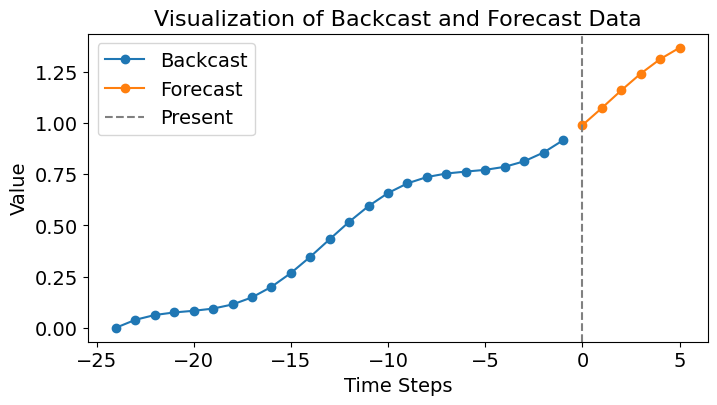

In [ ]:
plot_sample_data(sample_x, sample_y, backcast_length, forecast_length)

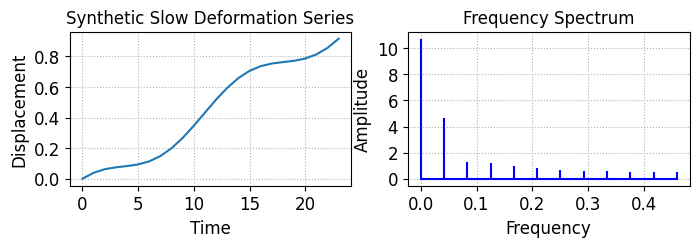

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Set up directory for saving results
save_dir = 'synthetic_results'
os.makedirs(save_dir, exist_ok=True)

# Assuming 'sample_x' and 'sample_y' are defined from the preceding analysis,
# perform a Fast Fourier Transform (FFT) to identify frequency components.

fft_result = np.fft.fft(sample_x[0])  # Conduct FFT on the first series of sample_x
frequencies = np.fft.fftfreq(len(sample_x[0]), 1)  # Determine frequency bins with a unit sampling rate

# Visualize the time series data
plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1)
plt.plot(sample_x[0], label='Sample Time Series')  # Plot the time series
plt.title("Synthetic Slow Deformation Series", fontsize=12)  # Corrected title for clarity and brevity
plt.xlabel("Time", fontsize=12)  # Label for the x-axis indicating time
plt.ylabel("Displacement", fontsize=12)  # Label for the y-axis indicating displacement
plt.grid(linestyle=':')  # Add grid lines for better readability
plt.xticks(fontsize=12)  # Adjust x-axis tick font size
plt.yticks(fontsize=12)  # Adjust y-axis tick font size

# Visualize the frequency spectrum
plt.subplot(1, 2, 2)
# Plot the magnitude of frequencies, considering only the positive half of the spectrum
plt.stem(frequencies[:len(frequencies)//2], np.abs(fft_result)[:len(frequencies)//2], 'b', markerfmt=" ", basefmt="-b")
plt.title("Frequency Spectrum", fontsize=12)  # Title for the frequency spectrum subplot
plt.xlabel("Frequency", fontsize=12)  # Label for the x-axis indicating frequency
plt.ylabel("Amplitude", fontsize=12)  # Label for the y-axis indicating amplitude
plt.grid(linestyle=':')  # Add grid lines for better readability
plt.xticks(fontsize=12)  # Adjust x-axis tick font size
plt.yticks(fontsize=12)  # Adjust y-axis tick font size

plt.savefig(os.path.join(save_dir, 'synthetic_plot_slow_deformation.pdf'))  # Save the figure
plt.show()  # Display the generated plots



The first plot shows a synthetic slow deformation series over a 25-time step period. The data exhibits a clear increasing trend, with the deformation value rising gradually from approximately 0.0 to 0.8 over the observed timeframe. Superimposed on this overall increasing trend, the time series plot also suggests the presence of an underlying periodic or cyclic component.

To further investigate the periodic characteristics of the data, the second plot presents the frequency spectrum obtained through a Fast Fourier Transform (FFT) analysis. The frequency spectrum reveals a prominent peak centered around 0.067 Hz, which corresponds to a period of approximately 15 time steps (1 / 0.067 Hz = 15 time steps).

This dominant peak in the frequency domain confirms the periodic behavior observed in the time series plot. The clear and focused nature of the peak indicates that the time series data is predominantly composed of a low-frequency, cyclic component with a period of roughly 15 time steps.

The sharp drop-off in amplitude at higher frequencies suggests that the synthetic deformation data does not contain significant high-frequency fluctuations. This observation is consistent with the smooth, gradually varying trend seen in the time series plot, where abrupt or rapid changes in deformation are absent.


Overall, the combined analysis of the time series plot and the corresponding frequency spectrum provides a comprehensive understanding of the underlying characteristics of the synthetic slow deformation data. The data exhibits a clear increasing trend, superimposed with a prominent low-frequency periodic component having a period of approximately 15 time steps.

In [ ]:
# Obtain the name of the backend from the NBeatsNet class.
backend_name = NBeatsNet.name()
print(f'Running the example for {backend_name}...')

# Instantiate the model with specific configurations.
# The configurations are empirically chosen based on common practices or default values.
model = NBeatsNet(
    backcast_length=backcast_length,  # Length of input series to the model.
    forecast_length=forecast_length,  # Length of output series from the model.
    stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.TREND_BLOCK, NBeatsNet.SEASONALITY_BLOCK),
    # Stacking different types of blocks to capture generic, trend, and seasonality patterns.
    nb_blocks_per_stack=2,  # Number of blocks per stack, set empirically.
    thetas_dim=(4, 4, 4),  # The dimension of theta parameters for each stack type, often set as default.
    hidden_layer_units=20  # The number of units in hidden layers, determined empirically.
)

# Compile the model with a mean absolute error loss function and the Adam optimizer.
model.compile(loss='mae', optimizer='adam')

# Fit the model on the training data, validate against test data, and iterate for a number of epochs.
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=32)

# Enable the model to output intermediate predictions for each block within the stacks.
model.enable_intermediate_outputs()

# Make a prediction using the model to demonstrate its intermediary output capturing capabilities.
model.predict(sample_x)  # This call also loads intermediary outputs into our model object for inspection.

Running the example for NBeatsPytorch...
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=20, thetas_dim=4, backcast_length=24, forecast_length=6, share_thetas=False) at @134168778277024
     | -- GenericBlock(units=20, thetas_dim=4, backcast_length=24, forecast_length=6, share_thetas=False) at @134168363470560
| --  Stack Trend (#1) (share_weights_in_stack=False)
     | -- TrendBlock(units=20, thetas_dim=4, backcast_length=24, forecast_length=6, share_thetas=True) at @134168363536864
     | -- TrendBlock(units=20, thetas_dim=4, backcast_length=24, forecast_length=6, share_thetas=True) at @134168798772240
| --  Stack Seasonality (#2) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=20, thetas_dim=6, backcast_length=24, forecast_length=6, share_thetas=True) at @134168364266256
     | -- SeasonalityBlock(units=20, thetas_dim=6, backcast_length=24, forecast_length=6, share_thetas=True) at @134168778289648
Epoch 01/20
1000/1000 [

array([[0.98828137, 1.0718683 , 1.1576418 , 1.2398785 , 1.3107133 ,
        1.3663421 ]], dtype=float32)

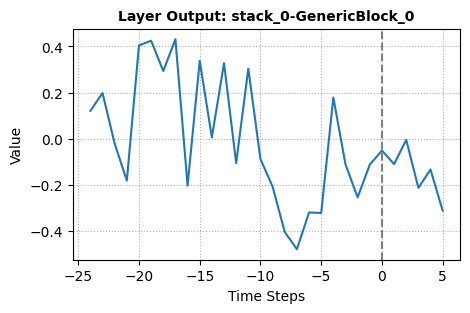

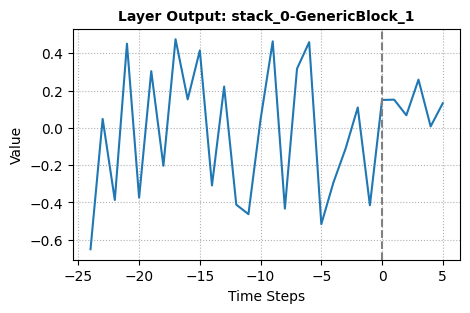

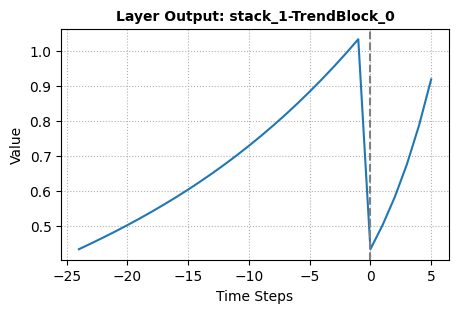

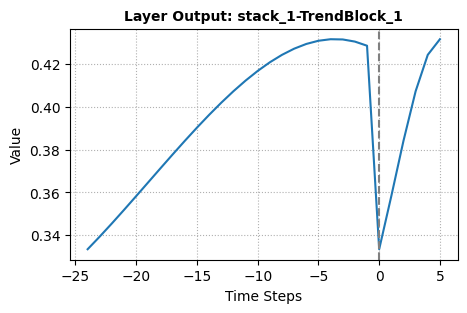

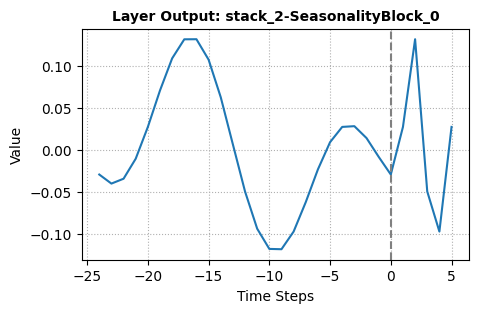

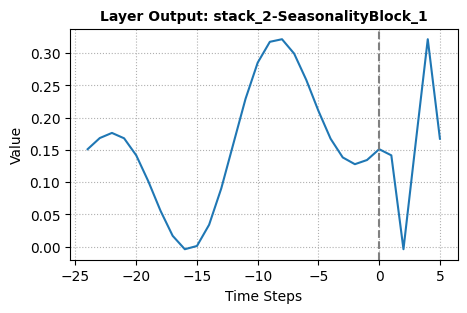

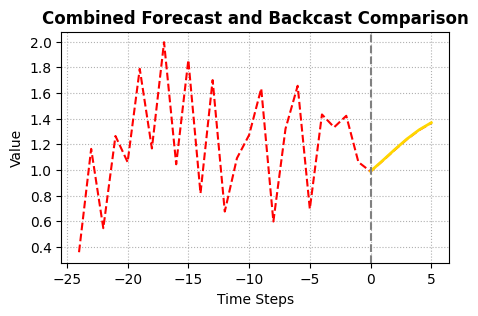

In [ ]:

predictions, outputs = model.get_generic_and_interpretable_outputs()
g_forecast = predictions['generic_forecast']
i_forecast = predictions['interpretable_forecast']
combined_forecast = g_forecast + i_forecast



# This function visualizes the outputs of each layer, both the backcast and forecast.
# It is imperative for understanding the contribution of each individual layer
# to the model's decision-making process. The time steps are arranged to show
# backcast and forecast values contiguously, and a vertical line demarcates the
# transition from backcast to forecast.
def plot_layer_outputs(outputs):
    for layer, data in outputs.items():
        # Define the range of time steps, with negative values for backcast and positive for forecast.
        time_steps = np.arange(-len(data['backcast']), len(data['forecast']))
        # Plot the concatenated backcast and forecast values.
        plt.figure(figsize=(5, 3))
        plt.plot(time_steps, np.concatenate([data['backcast'], data['forecast']]), label=f'{layer} Output', linestyle='-')
        plt.axvline(x=0, color='grey', linestyle='--')  # Draw a dividing line at the transition point (time step 0).
        plt.title(f'Layer Output: {layer}',fontweight='bold',fontsize=10)
        plt.xlabel('Time Steps',fontsize=10)
        plt.ylabel('Value',fontsize=10)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid(linestyle=":")
        # plt.legend()
        pdf_filename = f'{layer}_featuremap_slow_deformation_synthetic.pdf'
        plt.savefig(os.path.join(save_dir, pdf_filename))
        plt.show()
# This function compares the combined model output against the actual targets,
# serving as an evaluation of the model's forecasting accuracy. The combined
# output is the sum of the generic and interpretable backcast and forecast,
# which provides a comprehensive view of the model's performance.
def plot_combined_forecast_backcast(predictions, sample_y):
    # Establish the range of time steps for plotting.
    time_steps = np.arange(-len(predictions['generic_backcast']), len(predictions['generic_forecast']))
    # Combine the backcast and forecast predictions for a holistic output representation.
    combined_backcast = predictions['generic_backcast'] + predictions['interpretable_backcast']
    combined_forecast = predictions['generic_forecast'] + predictions['interpretable_forecast']

    # Plot the combined forecast/backcast and actual target values.
    plt.figure(figsize=(5, 3))
    plt.plot(time_steps, np.concatenate([combined_backcast, combined_forecast]), label='Combined Output', color='red', linestyle='--')
    plt.plot(range(len(sample_y)), sample_y, label='Actual Target', color='gold', linewidth=2)
    plt.axvline(x=0, color='grey', linestyle='--')  # Again, demarcate the backcast-forecast transition.
    plt.title('Combined Forecast and Backcast Comparison',fontweight='bold',fontsize=12)
    plt.xlabel('Time Steps',fontsize=10)
    plt.ylabel('Value',fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(linestyle=":")
    # plt.legend()
    pdf_filename = f'combine_forecating_slow_deformation_synthetic.pdf'
    plt.savefig(os.path.join(save_dir, pdf_filename))
    plt.show()

# Invoke the visualization functions with the model's outputs.
# These visualizations are crucial for the interpretation of the model's learning process
# and for assessing the efficacy of the model in capturing and projecting the relevant
# features of the time series data.
plot_layer_outputs(outputs)
plot_combined_forecast_backcast(predictions, sample_y)


The seasonal blocks exhibit a consistent cyclical behavior, capturing a periodicity of 15 time steps, which aligns with the observed data's inherent seasonality. This suggests that the network is adept at identifying and modeling the underlying periodic nature of the time series.


In terms of trend, the network demonstrates a consistent ability to detect an ascending trend within the data. The trend blocks effectively abstract the overall direction of the time series, disregarding the finer oscillations to provide a clear picture of the long-term movement. This characteristic illustrates the model's proficiency in distinguishing between the overarching progression of the dataset and its seasonal fluctuations. The persistent upward trajectory captured by the trend blocks underpins the model's interpretative strength in delineating growth trends across diverse time series datasets.

# Experiment 1.2: Simulating Seasonality-Driven Deformation States with Synthetic Data
## Objective
The primary goal of this experiment is to simulate deformation processes that are predominantly driven by seasonal factors, which are typical in geophysical phenomena influenced by hydrological drivers such as rainfall or reservoir water level fluctuations. By generating and employing synthetic data that exhibit pronounced seasonal characteristics, we aim to replicate the oscillatory deformation patterns that follow seasonal hydrological processes, thus exploring the STEN's capabilities in capturing and forecasting seasonally induced deformation behaviors.
## Data Generation
The `dummy_data_generator` function is crafted to generate synthetic datasets that closely resemble real-world seasonal signals. These datasets are created to reflect deformation patterns that oscillate in response to seasonal hydrological drivers, which are often seen in cases like rain-induced and reservoir-induced landslides. Below is a brief overview of the data generation strategy implemented:


In [ ]:
import numpy as np

# Adjust the dummy_data_generator to include more complex seasonality components.
def dummy_data_generator(backcast_length, forecast_length, signal_type='seasonality', random=False, batch_size=32):
    def get_x_y():
        lin_space = np.linspace(-backcast_length, forecast_length, backcast_length + forecast_length)
        if random:
            offset = np.random.standard_normal() * 0.1
        else:
            offset = 0  # Set offset to zero to reduce linear trend influence and increase seasonality visibility.

        if signal_type == 'trend':
            a = lin_space + offset
        elif signal_type == 'seasonality':
            # More complex seasonality with different frequencies, amplitudes, and phase shifts.
            a = np.sum([
                0.5 * np.sin(2 * np.pi * (1/10) * lin_space),  # Long cycle
                0.3 * np.sin(2 * np.pi * (1/5) * lin_space + np.pi/4),  # Medium cycle with phase shift
                0.2 * np.sin(2 * np.pi * lin_space + np.pi/2)  # Short cycle with phase shift
            ], axis=0)
        elif signal_type == 'cos':
            a = np.cos(2 * np.pi * lin_space)
        else:
            raise Exception('Unknown signal type.')

        x = a[:backcast_length]
        y = a[backcast_length:]

        # Normalize the values to be between 0 and 1 for consistency
        min_x, max_x = np.min(x), np.max(x)
        x = (x - min_x) / (max_x - min_x)
        y = (y - min_x) / (max_x - min_x)

        return x, y

    def gen():
        while True:
            xx = []
            yy = []
            for i in range(batch_size):
                x, y = get_x_y()
                xx.append(x)
                yy.append(y)
            yield np.array(xx), np.array(yy)

    return gen()

In [ ]:
# Setup data generator
backcast_length = 24
forecast_length = 6
data_gen = dummy_data_generator(
    backcast_length=backcast_length, forecast_length=forecast_length,
    signal_type='seasonality', random=False, batch_size=32
)

In [ ]:
# Generate data for training and testing
num_samples_train = 1000
num_samples_test = 200
batches = list(itertools.islice(data_gen, num_samples_train))
x_train = np.vstack([b[0] for b in batches])
y_train = np.vstack([b[1] for b in batches])

batches = list(itertools.islice(data_gen, num_samples_test))
x_test = np.vstack([b[0] for b in batches])
y_test = np.vstack([b[1] for b in batches])

sample_idx = 10
sample_x = x_test[sample_idx:sample_idx + 1]
sample_y = y_test[sample_idx]

In [ ]:
# Visualization
def plot_sample_data(sample_x, sample_y, backcast_length, forecast_length):
    time_steps_backcast = np.arange(-backcast_length, 0)
    time_steps_forecast = np.arange(0, forecast_length)

    plt.figure(figsize=(8, 4))
    plt.plot(time_steps_backcast, sample_x.flatten(), marker='o', label='Backcast')
    plt.plot(time_steps_forecast, sample_y, marker='o', label='Forecast')
    plt.axvline(x=0, color='gray', linestyle='--', label='Present')
    plt.title('Visualization of Backcast and Forecast Data', fontsize=16)
    plt.xlabel('Time Steps', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.tick_params(labelsize=14)  # Increased tick label size
    plt.legend(fontsize=14)
    plt.show()

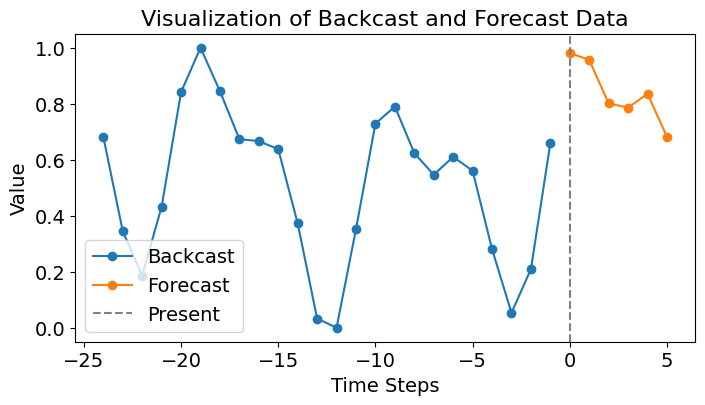

In [ ]:
plot_sample_data(sample_x, sample_y, backcast_length, forecast_length)

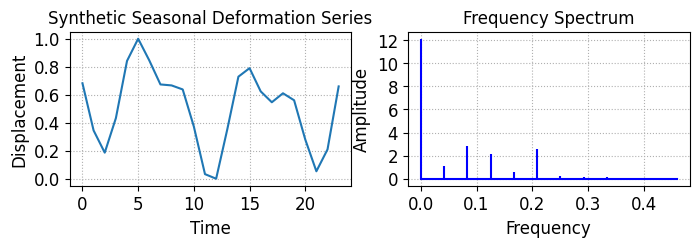

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Set up directory for saving results
save_dir = 'synthetic_results'
os.makedirs(save_dir, exist_ok=True)

# Assuming 'sample_x' and 'sample_y' are defined from the preceding analysis,
# perform a Fast Fourier Transform (FFT) to identify frequency components.

fft_result = np.fft.fft(sample_x[0])  # Conduct FFT on the first series of sample_x
frequencies = np.fft.fftfreq(len(sample_x[0]), 1)  # Determine frequency bins with a unit sampling rate

# Visualize the time series data
plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1)
plt.plot(sample_x[0], label='Sample Time Series')  # Plot the time series
plt.title("Synthetic Seasonal Deformation Series", fontsize=12)  # Corrected title for clarity and brevity
plt.xlabel("Time", fontsize=12)  # Label for the x-axis indicating time
plt.ylabel("Displacement", fontsize=12)  # Label for the y-axis indicating displacement
plt.grid(linestyle=':')  # Add grid lines for better readability
plt.xticks(fontsize=12)  # Adjust x-axis tick font size
plt.yticks(fontsize=12)  # Adjust y-axis tick font size

# Visualize the frequency spectrum
plt.subplot(1, 2, 2)
# Plot the magnitude of frequencies, considering only the positive half of the spectrum
plt.stem(frequencies[:len(frequencies)//2], np.abs(fft_result)[:len(frequencies)//2], 'b', markerfmt=" ", basefmt="-b")
plt.title("Frequency Spectrum", fontsize=12)  # Title for the frequency spectrum subplot
plt.xlabel("Frequency", fontsize=12)  # Label for the x-axis indicating frequency
plt.ylabel("Amplitude", fontsize=12)  # Label for the y-axis indicating amplitude
plt.grid(linestyle=':')  # Add grid lines for better readability
plt.xticks(fontsize=12)  # Adjust x-axis tick font size
plt.yticks(fontsize=12)  # Adjust y-axis tick font size

plt.savefig(os.path.join(save_dir, 'synthetic_plot_seasonality_deformation.pdf'))  # Save the figure



From the top plot, we can observe a periodic, oscillatory pattern in the deformation values. The deformation appears to fluctuate between approximately 0.2 and 0.8 over a period of around 10 time steps. This suggests the presence of a periodic, seasonal component in the deformation data.

The frequency spectrum plot in the bottom panel further confirms the periodic nature of the deformation series. The plot shows a dominant peak at a frequency of around 0.1, indicating that the primary frequency component in the data has a period of approximately 10 time steps. This corroborates the visual observation of the repeating pattern in the top plot.

In summary, the analysis of the provided data suggests that the Synthetic Seasonal Deformation Series exhibits a clear periodic behavior with a dominant period of around 10 time steps. This periodic pattern is evident in both the time-domain representation of the deformation values and the frequency-domain analysis of the series.


In [ ]:
# Obtain the name of the backend from the NBeatsNet class.
backend_name = NBeatsNet.name()
print(f'Running the example for {backend_name}...')

# Instantiate the model with specific configurations.
# The configurations are empirically chosen based on common practices or default values.
model = NBeatsNet(
    backcast_length=backcast_length,  # Length of input series to the model.
    forecast_length=forecast_length,  # Length of output series from the model.
    stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.TREND_BLOCK, NBeatsNet.SEASONALITY_BLOCK),
    # Stacking different types of blocks to capture generic, trend, and seasonality patterns.
    nb_blocks_per_stack=2,  # Number of blocks per stack, set empirically.
    thetas_dim=(4, 4, 4),  # The dimension of theta parameters for each stack type, often set as default.
    hidden_layer_units=20  # The number of units in hidden layers, determined empirically.
)

# Compile the model with a mean absolute error loss function and the Adam optimizer.
model.compile(loss='mae', optimizer='adam')

# Fit the model on the training data, validate against test data, and iterate for a number of epochs.
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=32)

# Enable the model to output intermediate predictions for each block within the stacks.
model.enable_intermediate_outputs()

# Make a prediction using the model to demonstrate its intermediary output capturing capabilities.
model.predict(sample_x)  # This call also loads intermediary outputs into our model object for inspection.

Running the example for NBeatsPytorch...
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=20, thetas_dim=4, backcast_length=24, forecast_length=6, share_thetas=False) at @134168228418352
     | -- GenericBlock(units=20, thetas_dim=4, backcast_length=24, forecast_length=6, share_thetas=False) at @134168227477008
| --  Stack Trend (#1) (share_weights_in_stack=False)
     | -- TrendBlock(units=20, thetas_dim=4, backcast_length=24, forecast_length=6, share_thetas=True) at @134168228425408
     | -- TrendBlock(units=20, thetas_dim=4, backcast_length=24, forecast_length=6, share_thetas=True) at @134168228418736
| --  Stack Seasonality (#2) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=20, thetas_dim=6, backcast_length=24, forecast_length=6, share_thetas=True) at @134168228429008
     | -- SeasonalityBlock(units=20, thetas_dim=6, backcast_length=24, forecast_length=6, share_thetas=True) at @134168228424928
Epoch 01/20
1000/1000 [

array([[0.9815455 , 0.95684433, 0.80193055, 0.7870015 , 0.8353602 ,
        0.68255496]], dtype=float32)

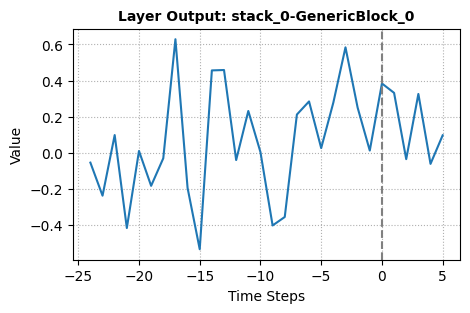

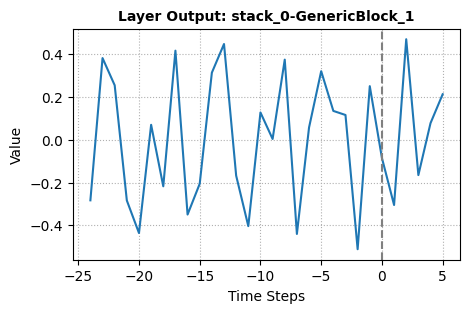

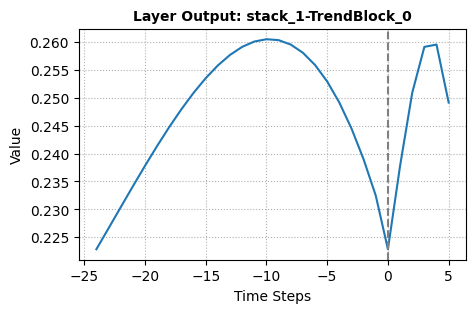

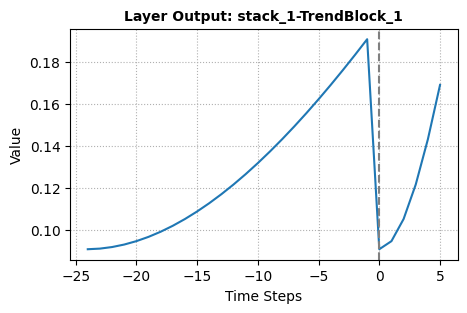

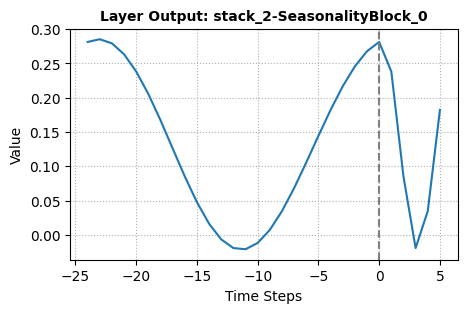

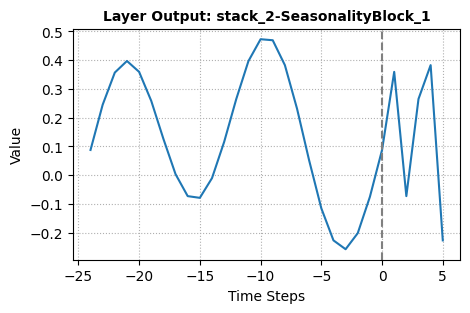

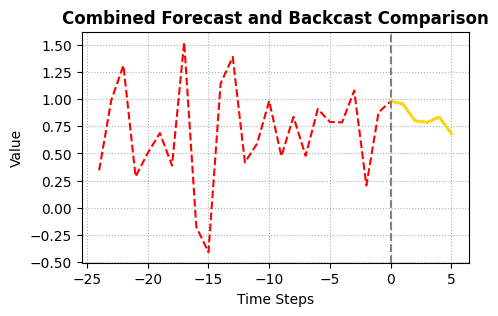

In [ ]:

predictions, outputs = model.get_generic_and_interpretable_outputs()
g_forecast = predictions['generic_forecast']
i_forecast = predictions['interpretable_forecast']
combined_forecast = g_forecast + i_forecast



# This function visualizes the outputs of each layer, both the backcast and forecast.
# It is imperative for understanding the contribution of each individual layer
# to the model's decision-making process. The time steps are arranged to show
# backcast and forecast values contiguously, and a vertical line demarcates the
# transition from backcast to forecast.
def plot_layer_outputs(outputs):
    for layer, data in outputs.items():
        # Define the range of time steps, with negative values for backcast and positive for forecast.
        time_steps = np.arange(-len(data['backcast']), len(data['forecast']))
        # Plot the concatenated backcast and forecast values.
        plt.figure(figsize=(5, 3))
        plt.plot(time_steps, np.concatenate([data['backcast'], data['forecast']]), label=f'{layer} Output', linestyle='-')
        plt.axvline(x=0, color='grey', linestyle='--')  # Draw a dividing line at the transition point (time step 0).
        plt.title(f'Layer Output: {layer}',fontweight='bold',fontsize=10)
        plt.xlabel('Time Steps',fontsize=10)
        plt.ylabel('Value',fontsize=10)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid(linestyle=":")
        # plt.legend()
        pdf_filename = f'{layer}_featuremap_seasonality_deformation_synthetic.pdf'
        plt.savefig(os.path.join(save_dir, pdf_filename))
        plt.show()
# This function compares the combined model output against the actual targets,
# serving as an evaluation of the model's forecasting accuracy. The combined
# output is the sum of the generic and interpretable backcast and forecast,
# which provides a comprehensive view of the model's performance.
def plot_combined_forecast_backcast(predictions, sample_y):
    # Establish the range of time steps for plotting.
    time_steps = np.arange(-len(predictions['generic_backcast']), len(predictions['generic_forecast']))
    # Combine the backcast and forecast predictions for a holistic output representation.
    combined_backcast = predictions['generic_backcast'] + predictions['interpretable_backcast']
    combined_forecast = predictions['generic_forecast'] + predictions['interpretable_forecast']

    # Plot the combined forecast/backcast and actual target values.
    plt.figure(figsize=(5, 3))
    plt.plot(time_steps, np.concatenate([combined_backcast, combined_forecast]), label='Combined Output', color='red', linestyle='--')
    plt.plot(range(len(sample_y)), sample_y, label='Actual Target', color='gold', linewidth=2)
    plt.axvline(x=0, color='grey', linestyle='--')  # Again, demarcate the backcast-forecast transition.
    plt.title('Combined Forecast and Backcast Comparison',fontweight='bold',fontsize=12)
    plt.xlabel('Time Steps',fontsize=10)
    plt.ylabel('Value',fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(linestyle=":")
    # plt.legend()
    pdf_filename = f'combine_forecating_seasonality_deformation_synthetic.pdf'
    plt.savefig(os.path.join(save_dir, pdf_filename))
    plt.show()

# Invoke the visualization functions with the model's outputs.
# These visualizations are crucial for the interpretation of the model's learning process
# and for assessing the efficacy of the model in capturing and projecting the relevant
# features of the time series data.
plot_layer_outputs(outputs)
plot_combined_forecast_backcast(predictions, sample_y)


Visualizing the features extracted by the N-Beats neural network alongside the original time series and its frequency spectrum reveals insights into the model's learning process. The `GenericBlock` outputs capture high-frequency components, suggesting sensitivity to short-term variations, potentially including noise. Conversely, the `TrendBlock` outputs distill low-frequency trends, uncovering a long-term upward trajectory aligned with the underlying data pattern. This differentiation between high and low-frequency learning highlights the network's ability to decompose time series into interpretable components.

Furthermore, the `SeasonalityBlock` outputs closely resemble the inherent periodicity observed in the raw data, accurately reflecting a cyclical pattern with a period of 10-time steps. This consistency demonstrates the network's proficiency in identifying and replicating seasonal fluctuations inherent to the dataset.


These results demonstrate that the network effectively segregates the time series into distinct layers of abstraction, each reflecting specific data characteristics. Generic blocks capture transient fluctuations, trend blocks encapsulate the gradual rise, and seasonality blocks echo the rhythmic cycles. This decomposition offers a granular understanding of the network's interpretive capabilities and underscores its potential for discerning intricate temporal dynamics.

In [ ]:
import os
from google.colab import files

# folder_path = '/content/synthetic_results'
# zip_path = '/content/synthetic_results.zip'
# os.system(f"zip -r {zip_path} {folder_path}")
# files.download(zip_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Conclusion
In summary, even without extensive parameter optimization, our STEN network, adhering to default architectural configurations, has effectively revealed seasonal and trend patterns within synthetic data through its feature extractions. Here, we find that STEN can extract features that reflect a spectrum of oscillatory modes from high to low frequency and discernible trends. The following notebooks of our investigation will focus on the visualization of extracted features from actual deformation data using the network.
